# Projet méthodes pour la science des données

# I. Chargement des données

In [1]:
import pandas as pd

df=pd.read_csv('Dataset/claimskg_result.csv')

# II. Informations sur le dataframe

In [2]:
shape=df.shape
print("Nombre d'enregistrements : ")
print(shape[0])
print("Nombre de colonnes : ")
print(shape[1])
print("Informations sur les colonnes")
df.info()

Nombre d'enregistrements : 
10000
Nombre de colonnes : 
14
Informations sur les colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      10000 non-null  object
 1   text                    10000 non-null  object
 2   date                    10000 non-null  object
 3   truthRating             10000 non-null  int64 
 4   ratingName              10000 non-null  object
 5   author                  10000 non-null  object
 6   headline                9882 non-null   object
 7   named_entities_claim    9864 non-null   object
 8   named_entities_article  6497 non-null   object
 9   keywords                8691 non-null   object
 10  source                  10000 non-null  object
 11  sourceURL               10000 non-null  object
 12  link                    10000 non-null  object
 13  language          

On observe qu'il n'existe qu'un seul champs dont le type des valeurs est numérique : truthRating qui indique si l'affirmation est vraie, fausse ou un mélange de vraies et de fausses informations. Les autres types correspondent tous à des chaîne de caractères.

# III. Feature engeenering

## III.a. Supression des colonnes inutiles

Parmi les colonnes du Dataframe, certaines colonnes ne sont pas nécessaire pour les tâches de classification. On peut par exemple vérifier qu'il y'a une bijection entre l'ensemble des valeurs de truthRating et l'ensemble des valeurs de ratingName.

In [3]:
g=df.groupby(['truthRating', 'ratingName'])
print(g['id'].count())

truthRating  ratingName
-1           OTHER         1761
 1           FALSE         3665
 2           MIXTURE       3247
 3           TRUE          1327
Name: id, dtype: int64


On peut donc supprimer au choix la colonne truthRating et ratingName car les valeurs seront de toute façon transformées lors de la création des features à l'étape suivante.

In [4]:
del df['ratingName']

On peut aussi supprimer la colonne language car tous les enregistrement dans le dataframe on la valeur 'English' pour cette colonne, elle n'est donc pas utile à l'apprentissage.

In [5]:
del df['language']

In [6]:
df.to_csv('Dataset/claimskg_columns_removed.csv')

## III.b. Valeurs manquantes

Ci-dessous sont présentés les nombres de chaînes de caractères vides par colonnes dans le dataframe.

In [7]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)

def count_empty_values(df):
    columns=df.columns[df.isnull().any()].tolist()
    for column in columns:
        print(column + " : " + str(df[column].isnull().sum()))

count_empty_values(df)

headline : 118
named_entities_claim : 136
named_entities_article : 3503
keywords : 1309


On remarque que toutes ces colonnes de type 'chaîne de caractère', on ne peut donc pas effectuer de calcul de moyennes pour remplir les informations manquantes. Il n'est pas non plus envisageables de supprimer les enregistrements correspondant car les autres colonnes portent des informations utiles à l'apprentissages.

On s'intéresse maintenant aux enregistrements qui ne portent pas la classe cible des tâches d'apprentissage :

In [8]:
print("Enregistrements non FALSE, TRUE ou MIXTURE : " + str(df[df['truthRating'] == -1].count()['id']))

Enregistrements non FALSE, TRUE ou MIXTURE : 1761


Comme ces enregistrements ne peuvent servir pour l'apprentissage, on peut se permettre de les supprimer.

In [9]:
df = df[df['truthRating'] != -1]
df = df.reset_index(drop=True)

On peut constater l'impact sur les valeurs manquantes des quatres colonnes contenant des valeurs nulles :

In [10]:
count_empty_values(df)

named_entities_claim : 11
named_entities_article : 2966
keywords : 464


On compte maintenant le nombre de date dont la valeur est unknown dans le dataframe

In [11]:
print(df[df['date'] == 'Unknown'].count()['id'])

3422


Les date étant sous forme de chaîne de caractère, nous choisissons de les convertir en timestamp afin que les algorithmes de classification puisse trouver, s'il en existe, certaines corrélations entre l'ancienneté d'une assertion et sa veracité. Nous remplacerons les valeurs 'Unknown' par la moyenne des timestamps obtenus.

In [12]:
import time
import datetime
from math import ceil

def convert_to_timestamp(datestring):
    return time.mktime(datetime.datetime.strptime(datestring, "%Y-%m-%d").timetuple())

# df_feature_date = df['date'].apply(convert_to_timestamp)['date']

timestamp_sum=0
number_of_dates = 0
for date in df['date']:
    if date != 'Unknown':
        timestamp_sum += convert_to_timestamp(date)
        number_of_dates = number_of_dates + 1

timestamp_mean = ceil(timestamp_sum / number_of_dates)

def process_dates(date):
    if date == 'Unknown':
        return timestamp_mean
    else:
        return convert_to_timestamp(date)

df_timestamp = pd.DataFrame(df['date'].apply(process_dates))

## III.c. Pré-traitement du texte d'une affirmation

On commence par importer la bibliothèque NLTK (Natural Language ToolKit)

In [13]:
import nltk

from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

Puis on défini la fonction de pré-traitement du texte d'une affirmation.
Celle-ci contient les étapes suivantes :
- Suppression des formes contractées de la langue anglaise
- Remplacement des chiffres par des mots
- Suppression des ponctuations
- Normalisation de la casse (tout est mis en minuscule)
- Suppression des mots non utiles à la classification (Stop words)
- Reduction des mots à leurs racines (Lemmatization)

In [14]:
import inflect
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

p = inflect.engine()
stop_words = set(stopwords.words('english'))
    
def replace_contractions(text):
    return contractions.fix(text)

def tokenize(text):
    return word_tokenize(text)

def replace_numbers(word):
    if (word.isdigit()):
        return p.number_to_words(word)
    else:
        return word

def remove_punctuations(words):
    return [word for word in words if word.isalpha()]

def normalize_case(word):
    return word.lower()

def filter_stop_words(words):
    return [word for word in words if not word in stop_words]

def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word, pos='v')

def process_text(text):
    text = replace_contractions(text)

    words = tokenize(text)
    words = map(replace_numbers, words)
    words = remove_punctuations(words)
    words = map(normalize_case, words)
    words = filter_stop_words(words)
    words = map(lemmatize_word, words)
    
    return ' '.join(words)

In [15]:
# df_rows_removed : DataFrame dont les enregistrements avec une valeur de truthRating égale à -1 sont supprimés
df_rows_removed = df.copy()
df = pd.DataFrame(df['text'].apply(process_text))
print(df['text'].values)

['revenue generate drill virginia coast forty million ten years'
 'health insurance company pay ceos million year'
 'ted cruz say veterans start sell cookies order raise fund' ...
 'management charge discriminate break federal law'
 'naacp call removal historical civil war carve stone mountain georgia'
 'cruz try ban contraception five time']


## III.d. Extraction des features à partir du texte de l'assertion

Nous allons utilisé la classe TfidVectorizer pour produire à partir de chaque mots du texte pré-traité de chaque assertion une feature dont la valeur correspond à la fréquence d'apparition du mot dans le texte. 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

features_text = vectorizer.fit_transform(df['text'])

print(df.shape)

df_features_text = pd.DataFrame(
    data=vectorizer.transform(df['text']).toarray(),
    columns=vectorizer.get_feature_names()
)

print(df_features_text.shape)

(8239, 1)
(8239, 10624)


## III.Ajout de la feature de l'auteur

On converti chaque auteur comme une colonne en indiquant s'il est un auteur (1) ou pas (0). On utilise one hot encoding car il n'y a pas d'ordre entre les différents auteurs. 

In [17]:
df_modified_author = df_rows_removed.copy()

print ("\n Affichage des transformations\n")
print (pd.get_dummies(df_modified_author[['author']]))

print ("\nAjout des colonne au dataframe")
df_author = pd.get_dummies(df_modified_author,columns=['author'], prefix = ['Auth'])

display(df_author)



 Affichage des transformations

      author_ Americans For Prosperity, North Carolina chapter  \
0                                                     0          
1                                                     0          
2                                                     0          
3                                                     0          
4                                                     0          
...                                                 ...          
8234                                                  0          
8235                                                  0          
8236                                                  0          
8237                                                  0          
8238                                                  0          

      author_ Save Our City, Milwaukeeans Can't Wait  \
0                                                  0   
1                                                  0   
2     

,id,text,date,truthRating,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,...,Auth_Zell Miller,Auth_Zoe Lofgren,Auth_billhislam.com,Auth_dailynewsforamericans.com,Auth_delta-flying.info,Auth_nofakenews-online,Auth_teaparty.org,Auth_tmzbreaking,Auth_world-newss.com,Auth_worldnewsdailyreport.com
0,http://data.gesis.org/claimskg/claim_review/c2...,'And the revenue generated by drilling off Vir...,2012-02-15,2,Moran says drilling off Virginia's coast will ...,"Alaska,American Petroleum Institute,Atlantic O...",NaN,"Energy,State Finances",politifact,http://www.politifact.com,...,0,0,0,0,0,0,0,0,0,0
1,http://data.gesis.org/claimskg/claim_review/1e...,Health insurance companies pay CEOs $24 millio...,2009-09-15,2,Health care advocacy group blasts insurers for...,"Aetna,Assurant,Bloomberg News,Cigna,Coventry H...",NaN,"Corporations,Health Care",politifact,http://www.politifact.com,...,0,0,0,0,0,0,0,0,0,0
2,http://data.gesis.org/claimskg/claim_review/0b...,Ted Cruz said that veterans should start selli...,Unknown,1,Ted Cruz: Vets Should Sell Cookies for Funding...,"David Nelson,James Morrison,John Scalzi,Republ...",Ted Cruz,"ASP Article, Not Necessarily The News",snopes,http://www.snopes.com,...,0,0,0,0,0,0,0,0,0,0
3,http://data.gesis.org/claimskg/claim_review/a1...,Passengers on an airliner diverted to Cuba tho...,Unknown,2,Did Airline Passengers Mistake a Hijacking for...,"Allen Funt,Associated Press,CBS,Candid Camera,...","Allen Funt,Candid Camera,Cuba","Broadcast Legends, Radio & TV, Television",snopes,http://www.snopes.com,...,0,0,0,0,0,0,0,0,0,0
4,http://data.gesis.org/claimskg/claim_review/b4...,Oil money from federal leases 'can only be use...,2009-06-15,2,Sen. Bill Nelson says offshore drilling won't ...,"Alabama,Bill Nelson,D-Fla,Florida Panhandle,Gu...",NaN,Environment,politifact,http://www.politifact.com,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,http://data.gesis.org/claimskg/claim_review/e8...,"While in the Illinois Senate, Barack Obama pas...",2008-08-25,2,Obama sponsored earned income tax credit,"Barack Obama,Illinois Senate,Internal Revenue ...","Barack Obama,Illinois Senate,hard-working fami...",Taxes,politifact,http://www.politifact.com,...,0,0,0,0,0,0,0,0,0,0
8235,http://data.gesis.org/claimskg/claim_review/d2...,'The tuitions in Virginia colleges...have doub...,2010-11-30,3,Bob McDonnell says Virginia college tuitions h...,"2009 Stimulus Act,Bob McDonnell,James Madison ...",NaN,Education,politifact,http://www.politifact.com,...,0,0,0,0,0,0,0,0,0,0
8236,http://data.gesis.org/claimskg/claim_review/0e...,'Trump Management was charged with discriminat...,2016-08-26,3,Clinton ad: Trump Management was charged with ...,"Art of the Deal,Civil Rights Act of 1968,Donal...",NaN,"Candidate Biography,Civil Rights,Housing,Legal...",politifact,http://www.politifact.com,...,0,0,0,0,0,0,0,0,0,0
8237,http://data.gesis.org/claimskg/claim_review/c9...,The NAACP is calling for the removal of an his...,Unknown,2,Does the NAACP Want to Sandblast Confederate F...,"Atlanta Journal-Constitution,Charleston massac...","NAACP,Stone Mountain, Georgia","NAACP, stone mountain",snopes,http://www.snopes.com,...,0,0,0,0,0,0,0,0,0,0


## III.e. Ajout de la colonne timestamp

On définit le DataFrame 'features' comme la jointure sur l'id des features extraits du texte avec le DataFrame contenant les timestamp

In [18]:
features = df_features_text.join(df_timestamp, lsuffix='_text')
display(features)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,zipper,zippo,zombie,zombies,zombism,zone,zoo,zuckerberg,zuma,date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.329260e+09
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.252966e+09
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.395176e+09
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.395176e+09
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.245017e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.219615e+09
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.291072e+09
8236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.472162e+09
8237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.395176e+09


In [19]:
#df_rows_removed.info()
#display(df_rows_removed)

## III.e. Création des features 

In [20]:
## IV.a. Ingénierie du texte

In [21]:
# from sklearn.model_selection import train_test_split 
# from sklearn.linear_model import SGDClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
# from sklearn.metrics import accuracy_score, confusion_matrix
# from time import time
#from sklearn.metrics import classification_report


# validation_size=0.3 #30% du jeu de données pour le test

# testsize= 1-validation_size
# seed=30



# pipeline = Pipeline([('vect', TfidfVectorizer()),
#                ('clf', SGDClassifier(loss='hinge', 
#                                      penalty='l2',
#                                      alpha=1e-3, 
#                                      random_state=42, 
#                                      max_iter=5, tol=None)),
#               ])




# X = df_claim_text_processed['text'].values
# y = df['truthRating']

# X_train,X_test,y_train,y_test=train_test_split(X, 
#                                               y, 
#                                               train_size=validation_size, 
#                                               random_state=seed,
#                                               test_size=testsize)


# t0 = time()
# pipeline.fit(X_train, y_train)
# print("Fit réalisé en %0.3fs" % (time() - t0))

# t0 = time()
# result = pipeline.predict(X_test)
# print("Prédiction réalisée en %0.3fs" % (time() - t0))

# print('\n accuracy:',accuracy_score(result, y_test),'\n')

# conf = confusion_matrix(y_test, result)
# print ('\n matrice de confusion \n',conf)

# print ('\n',classification_report(y_test, result))


In [22]:
df_test = features.join(pd.get_dummies(df_modified_author[['author']]))

df_test = df_test.join(pd.get_dummies(df_rows_removed[['source']]))

display(df_rows_removed['truthRating'])
truthRating = df_rows_removed['truthRating']
df_test = df_test.join(truthRating, lsuffix='_text')
display(df_test)


0       2
1       2
2       1
3       2
4       2
       ..
8234    2
8235    3
8236    3
8237    2
8238    2
Name: truthRating, Length: 8239, dtype: int64

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_teaparty.org,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,2
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,3
8236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,3
8237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,2


#Classification

In [23]:
df_test = df_test[df_test.truthRating != 2]
display(df_test)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_teaparty.org,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,3
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
8231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
8233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,3


In [24]:
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#Sickit learn met régulièrement à jour des versions et indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [25]:
#import seaborn as sns
#sns.heatmap(df.isnull(), cbar=False)
def k_fold_multi_classifier(df_values):
#df_values = df_test.values

    X = df_values[:,0:-1]

    y = df_values[:,-1]

    display(X)
    display(y)

    validation_size=0.3 #30% du jeu de données pour le test
    testsize= 1-validation_size
    seed=30

    X_train, X_test, y_train, y_test = train_test_split(X, y,
     train_size=validation_size,
     random_state=seed,test_size=testsize)

    seed = 7
    scoring = 'accuracy'
    models = []
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('RFO', RandomForestClassifier()))

    results = []
    names = []
    for name,model in models:
     kfold = KFold(n_splits=2, random_state=seed)
     cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
     results.append(cv_results)
     names.append(name)
     msg = "%s: %f (%f)" % (name, cv_results.mean(),
     cv_results.std())
     print(msg)


NameError: name 'results' is not defined

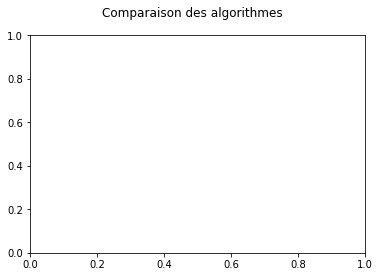

In [26]:
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

In [27]:
c = df_test.groupby(['truthRating'])
print(c['id'].count())

truthRating
1    3665
3    1327
Name: id, dtype: int64


Ici on voit que FALSE (1) est environ deux fois plus présent que TRUE (3)
Donc on fais un upsampling a TRUE pour equilibrer avec FALSE

In [28]:
from sklearn.utils import resample

TRUE = df_test[df_test.truthRating==3]
FALSE = df_test[df_test.truthRating==1]
#print(TRUE)
#print(FALSE)

TRUE_upsampled = resample(TRUE,
                          replace=True, # sample with replacement
                          n_samples=len(FALSE), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([FALSE, TRUE_upsampled])

# check new class counts
upsampled.truthRating.value_counts()

3    3665
1    3665
Name: truthRating, dtype: int64

In [29]:
display(upsampled['truthRating'])
display(df_test)
df_test = df_test.drop('truthRating', axis=1)
df_test = df_test.join(upsampled)
df_val = df_test.values

k_fold_multi_classifier(df_val)

2       1
5       1
7       1
9       1
15      1
       ..
6360    3
6216    3
3824    3
6987    3
4199    3
Name: truthRating, Length: 7330, dtype: int64

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_teaparty.org,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,3
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
8231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
8233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,3


ValueError: columns overlap but no suffix specified: Index(['aaa', 'aaron', 'ab', 'aba', 'abaco', 'abandon', 'abbey', 'abbott',
       'abbreviation', 'abby',
       ...
       'author_nofakenews-online', 'author_teaparty.org', 'author_tmzbreaking',
       'author_world-newss.com', 'author_worldnewsdailyreport.com',
       'source_africacheck', 'source_factscan', 'source_politifact',
       'source_snopes', 'source_truthorfiction'],
      dtype='object', length=12516)

In [ ]:
FALSE_downsampled = resample(FALSE,
                                replace = False, # sample without replacement
                                n_samples = len(TRUE), # match minority n
                                random_state = 27) # reproducible results

downsampled = pd.concat([FALSE_downsampled, TRUE])

downsampled.truthRating.value_counts()